<a href="https://colab.research.google.com/github/16SeungHun/CIFAR10---termproject/blob/main/Mymodel_pretrained_model_resnet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, datasets
from torch.autograd import Variable
from torch.optim import lr_scheduler
import os

import sys
import numpy as np

In [2]:
''' 2. 같은 결과값을 위한 시드 고정 '''
np.random.seed(3)

In [3]:
''' 3. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [4]:
''' 4. Batch size와 epochs 설정 '''
start_time = time.time()
batch_size = 32
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 32
default_directory = "../data/save_models"

EPOCHS = 10

In [5]:
''' 5. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize(224, interpolation=2),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize(224, interpolation=2),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [6]:
''' 6. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

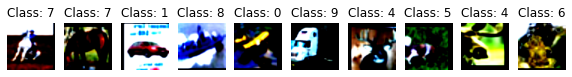

In [7]:
''' 7. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
''' 8. 전이학습, 사전훈련된 모델 사용(Resnet152) '''
model = models.resnet152(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
                                momentum=0.9,
                                nesterov=True)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [9]:
''' 9. ResNet-152 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(epoch):
    model.train()
    train_loss = 0 
    total = 0
    correct = 0


    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)

        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()


        if batch_idx % 10 == 0:
            print('Epoch: {} | Batch_idx: {} |  Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
                  .format(epoch, batch_idx, train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

In [10]:
''' 10. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        outputs = model(data)
        loss = criterion(outputs, target)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

    print('# TEST : Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
          .format(test_loss / (batch_idx + 1), 100. * correct / total, correct, total))

In [11]:
''' 11. 체크포인트 정의 '''
def save_checkpoint(directory, state, filename='latest.tar.gz'):

    if not os.path.exists(directory):
        os.makedirs(directory)

    model_filename = os.path.join(directory, filename)
    torch.save(state, model_filename)
    print("=> saving checkpoint")

def load_checkpoint(directory, filename='latest.tar.gz'):

    model_filename = os.path.join(directory, filename)
    if os.path.exists(model_filename):
        print("=> loading checkpoint")
        state = torch.load(model_filename)
        return state
    else:
        return None

In [ ]:
''' 12. 학습시작 '''
start_epoch = 0

checkpoint = load_checkpoint(default_directory)
if not checkpoint:
    pass
else:
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

for epoch in range(start_epoch, 110):
    train(epoch)
    save_checkpoint(default_directory, {
        'epoch': epoch,
        'model': model,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    })
    test()  

now = time.gmtime(time.time() - start_time)
print('{} hours {} mins {} secs for training'.format(now.tm_hour, now.tm_min, now.tm_sec))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch: 55 | Batch_idx: 1330 |  Loss: (0.0014) | Acc: (99.95%) (42572/42592)
Epoch: 55 | Batch_idx: 1340 |  Loss: (0.0013) | Acc: (99.95%) (42892/42912)
Epoch: 55 | Batch_idx: 1350 |  Loss: (0.0014) | Acc: (99.95%) (43211/43232)
Epoch: 55 | Batch_idx: 1360 |  Loss: (0.0014) | Acc: (99.95%) (43531/43552)
Epoch: 55 | Batch_idx: 1370 |  Loss: (0.0014) | Acc: (99.95%) (43851/43872)
Epoch: 55 | Batch_idx: 1380 |  Loss: (0.0015) | Acc: (99.95%) (44169/44192)
Epoch: 55 | Batch_idx: 1390 |  Loss: (0.0015) | Acc: (99.95%) (44488/44512)
Epoch: 55 | Batch_idx: 1400 |  Loss: (0.0015) | Acc: (99.95%) (44808/44832)
Epoch: 55 | Batch_idx: 1410 |  Loss: (0.0015) | Acc: (99.95%) (45128/45152)
Epoch: 55 | Batch_idx: 1420 |  Loss: (0.0016) | Acc: (99.95%) (45447/45472)
Epoch: 55 | Batch_idx: 1430 |  Loss: (0.0017) | Acc: (99.94%) (45766/45792)
Epoch: 55 | Batch_idx: 1440 |  Loss: (0.0017) | Acc: (99.94%) (46086/46112)
Epoch: 55 | Batch_idx: 1450 |  Loss: (0.0017) | Acc: